# Fire Size Predictors
Instead of straight out predicting fire size, this approach will be to first use a classifier to predict weather the fire will be small, medium or large. Then based on that prediction, use the corresponding regression model to predict the exact size.

In [1]:
import pandas as pd
import numpy as np
from helper_functions import evaluate_model
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer, PowerTransformer, MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.metrics import mean_squared_error, r2_score, f1_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import SGDClassifier, HuberRegressor, ElasticNetCV
from sklearn.naive_bayes import MultinomialNB
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline as imbPipeline
import xgboost as xgb

In [2]:
# import fire and weather data and combine into single dataframe
fire_df = pd.read_csv('data/wildfires_clean.csv')
weather_df = pd.read_csv('data/clean_weather.csv')
df = pd.merge(fire_df, weather_df, on='FID')
print(df.shape)
df.head()

(419872, 23)


,FID,Src_Agency,Latitude,Longitude,Rep_Date,Size_Ha,Cause,Protzone,Ecoz_Name,Year,...,Province,Size_Bin,Decade,Elevation,2_Week_Rainfall,Avg_High,Start_Date_High,Avg_Temp,Start_Date_Wind_Speed,Wind_Direction
0,0,BC,59.963,-128.172,1953-05-26,8.0,H,,Boreal Cordillera,1953,...,BC,small,50s,835.0,21.9,12.400000,15.1,7.126667,11.9,200
1,1,BC,59.318,-132.172,1950-06-22,8.0,L,,Boreal Cordillera,1950,...,BC,small,40s,835.0,13.0,19.766667,17.0,13.660000,10.5,342
2,2,BC,59.876,-131.922,1950-06-04,12949.9,H,,Boreal Cordillera,1950,...,BC,large,40s,853.0,11.2,9.146667,14.3,4.433333,12.9,310
3,3,BC,59.760,-132.808,1951-07-15,241.1,H,,Boreal Cordillera,1951,...,BC,medium,50s,952.0,32.0,21.940000,21.9,17.086667,5.2,343
4,4,BC,59.434,-126.172,1952-06-12,1.2,H,,Boreal Cordillera,1952,...,BC,small,50s,438.0,24.8,14.193333,21.2,9.986667,10.1,105


In [3]:
features = ['Latitude', 'Longitude', 'Year', 'Month', 'Date', 'Cause', 'Elevation', '2_Week_Rainfall', 'Avg_High', 'Start_Date_High', 'Avg_Temp', 'Start_Date_Wind_Speed', 'Wind_Direction', 'Size_Ha', 'Size_Bin']
X = df[features]

## Stage 1: Classifier

In [4]:
# check distribution of size bins
df['Size_Bin'].value_counts(normalize=True)

small     0.902980
medium    0.087034
large     0.009986
Name: Size_Bin, dtype: float64

In [4]:
# Create training and test data for classifier
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['Size_Ha', 'Size_Bin']), X['Size_Bin'], test_size=.3, random_state=58, stratify=X['Size_Bin'])

In [9]:
sgd_pipe = imbPipeline([
    # Scaling, Normalizng, Encoding
    ('preprocessing', ColumnTransformer([
        ('numeric', make_pipeline(
            PowerTransformer(),
            StandardScaler()),
            make_column_selector(dtype_include=np.number)
        ),
         ('categorical', make_pipeline(
             OneHotEncoder()),
             make_column_selector(dtype_include='object')
         )])
    ),
    # Sampling to address class imbalance
    ('smote_enn', SMOTEENN()),

    # classifier
    ('model', SGDClassifier())
])

In [10]:
sgd_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('powertransformer',
                                                                   PowerTransformer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD8FA8D730>),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD8FA8D0A0>)])),
                ('smote_enn', SMOTEENN()), ('model', SGDClassifier())])

In [14]:
clf_pred = sgd_pipe.predict(X_test)
f1 = f1_score(y_test, clf_pred, average=None)
print('F1 Score:', f1)
confusion_matrix(y_test, clf_pred)

F1 Score: [0.06717705 0.09628487 0.84073795]


array([[ 1110,    36,   112],
       [ 6217,   749,  3997],
       [24462,  3810, 85469]], dtype=int64)

In [15]:
# attempt with a naive bayes classifier
nbc_pipe = imbPipeline([
    # Scaling, Normalizng, Encoding
    ('preprocessing', ColumnTransformer([
        ('numeric', make_pipeline(
            PowerTransformer(),
            MinMaxScaler()),
            make_column_selector(dtype_include=np.number)
        ),
         ('categorical', make_pipeline(
             OneHotEncoder()),
             make_column_selector(dtype_include='object')
         )])
    ),
    # Sampling to address class imbalance
    ('smote_enn', SMOTEENN()),

    # classifier
    ('model', MultinomialNB())
])

In [16]:
nbc_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('powertransformer',
                                                                   PowerTransformer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD8DD2EF40>),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001FD8FAA1310>)])),
                ('smote_enn', SMOTEENN()), ('model', MultinomialNB())])

In [17]:
clf_pred = nbc_pipe.predict(X_test)
f1 = f1_score(y_test, clf_pred, average=None)
print('F1 Score:', f1)
print(confusion_matrix(y_test, clf_pred))

F1 Score: [0.0381741  0.00795372 0.70679376]
[[ 1111     2   145]
 [ 6701    44  4218]
 [49137    55 64549]]


In [37]:
# attempt with a Random Forest classifier
rfc_pipe = imbPipeline([
    # Scaling, Normalizng, Encoding
    ('preprocessing', ColumnTransformer([
        ('numeric', make_pipeline(
            PowerTransformer(),
            StandardScaler()),
            make_column_selector(dtype_include=np.number)
        ),
         ('categorical', make_pipeline(
             OneHotEncoder()),
             make_column_selector(dtype_include='object')
         )])
    ),
    # Sampling to address class imbalance
    ('smote_enn', SMOTEENN()),

    # classifier
    ('model', RandomForestClassifier())
])

In [39]:
rfc_pipe.fit(X_train, y_train)
clf_pred = rfc_pipe.predict(X_test)
f1 = f1_score(y_test, clf_pred, average=None)
print('F1 Score:', f1)
print(confusion_matrix(y_test, clf_pred))

F1 Score: [0.18821351 0.40855973 0.90889492]
[[  305   803   150]
 [  603  6835  3525]
 [ 1075 14858 97808]]


In [40]:
rfc_params = {
    'model__max_features': ['sqrt', 'log2', None]
}

rfc_grid = GridSearchCV(estimator=rfc_pipe, param_grid=rfc_params)
rfc_grid.fit(X_train, y_train)
clf_pred = rfc_grid.predict(X_test)
f1 = f1_score(y_test, clf_pred, average=None)
print('F1 Score:', f1)
print(confusion_matrix(y_test, clf_pred))

F1 Score: [0.19504547 0.40582212 0.90818494]
[[  311   787   160]
 [  601  6817  3545]
 [ 1019 15029 97693]]


In [41]:
rfc_grid.best_params_

{'model__max_features': 'log2'}

In [42]:
filename = 'models/rfcgrid.sav'
pickle.dump(rfc_grid, open(filename, 'wb'))


In [5]:
# XGBoost Classifier

#XGBoost requires encoded y values.
le = LabelEncoder()
X['Size_Bin'] = le.fit_transform(X['Size_Bin'])
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['Size_Ha', 'Size_Bin']), X['Size_Bin'], test_size=.3, random_state=58, stratify=X['Size_Bin'])



C:\Users\HP USER\AppData\Local\Temp\ipykernel_17244\2519040305.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Size_Bin'] = le.fit_transform(X['Size_Bin'])


In [8]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{'large': 0, 'medium': 1, 'small': 2}


In [9]:

xgc_pipe = imbPipeline([
    # Scaling, Normalizng, Encoding
    ('preprocessing', ColumnTransformer([
        ('numeric', make_pipeline(
            PowerTransformer(),
            StandardScaler()),
            make_column_selector(dtype_include=np.number)
        ),
         ('categorical', make_pipeline(
             OneHotEncoder()),
             make_column_selector(dtype_include='object')
         )])
    ),
    # Sampling to address class imbalance
    ('smote_enn', SMOTEENN()),

    # classifier
    ('model', xgb.XGBClassifier())
])

xgc_pipe.fit(X_train, y_train)
clf_pred = xgc_pipe.predict(X_test)
f1 = f1_score(y_test, clf_pred, average=None)
print('F1 Score:', f1)
print(confusion_matrix(y_test, clf_pred))

F1 Score: [0.16333938 0.36147093 0.9091246 ]
[[  675   450   133]
 [ 2072  5023  3868]
 [ 4260 11356 98125]]


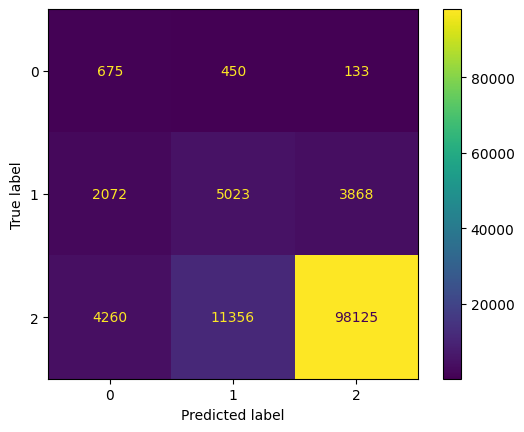

In [14]:
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(y_test, clf_pred)
cm_plot = ConfusionMatrixDisplay(cm, display_labels=xgc_pipe.classes_)
cm_plot.plot()

## Stage 2: Regressors
### Small Fire Regressor

In [41]:
# Create training and test data for small regressor
small_filter = X['Size_Bin'] == 'small'
X_train, X_test, y_train, y_test = train_test_split(X[small_filter].drop(columns=['Size_Ha', 'Size_Bin']), X[small_filter]['Size_Ha'], test_size=.3, random_state=58)

# Preprocessing Pipeline

# isolate categorical features
cat_feats = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()

# isolate numeric features
num_feats = X_train.dtypes[X_train.dtypes == np.number].index.tolist()

numeric_transform = Pipeline([
    ('transform', PowerTransformer()),
    ('scaler', StandardScaler()),
])
categorical_transform = Pipeline([
    ('encoder', OneHotEncoder())
])

preprocessing = ColumnTransformer([
    ('numeric', numeric_transform, num_feats),
    ('categorical', categorical_transform, cat_feats)
])


In [7]:
# AdaBoost model
adb_small_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('model', AdaBoostRegressor())
])

adb_small_pipe.fit(X_train, y_train)

evaluate_model(adb_small_pipe, X_test, y_test)


RMSE of the model: 2.406
R2 of the model: -0.338


In [9]:
adb_small_params = {
    'model__n_estimators': [50, 100],
    'model__loss': ['linear', 'square'],
    'model__learning_rate': [.001, .01]
}

adb_small_grid = GridSearchCV(estimator=adb_small_pipe, param_grid=adb_small_params)
adb_small_grid.fit(X_train, y_train)
evaluate_model(adb_small_grid, X_test, y_test)
print('Best Parameters:', adb_small_grid.best_params_)

RMSE of the model: 2.040
R2 of the model: 0.037
Best Parameters: {'model__learning_rate': 0.001, 'model__loss': 'linear', 'model__n_estimators': 50}


In [10]:
filename = 'models/adb_small_grid.sav'
pickle.dump(adb_small_grid, open(filename, 'wb'))

In [11]:
en_small_pipe =  Pipeline([
    ('preprocessing', preprocessing),
    ('model', ElasticNetCV())
])

en_small_pipe.fit(X_train, y_train)
evaluate_model(en_small_pipe, X_test, y_test)

RMSE of the model: 2.040
R2 of the model: 0.038


In [12]:
en_params = {
    'model__l1_ratio': [.1, .3, .5, .8,  1]
}
en_small_grid = GridSearchCV(estimator=en_small_pipe, param_grid=en_params)

en_small_grid.fit(X_train, y_train)
evaluate_model(en_small_grid, X_test, y_test)

RMSE of the model: 2.039
R2 of the model: 0.038


In [42]:
# XGBoost
xgb_small_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('model', xgb.XGBRegressor())
])

xgb_small_pipe.fit(X_train, y_train)
evaluate_model(xgb_small_pipe, X_test, y_test)

RMSE of the model: 1.977
R2 of the model: 0.096


In [43]:
xgb_small_pipe.score(X_train, y_train)

0.1837102380620621

In [44]:
xgb_params = {
    'model__eta': [.01, .1, .3],
    'model__max_depth': [2, 4, 6],
    'model__min_child_weight': [1, 10, 50]
}
xgb_small_grid = GridSearchCV(estimator=xgb_small_pipe, param_grid=xgb_params)
xgb_small_grid.fit(X_train, y_train)
evaluate_model(xgb_small_grid,X_test, y_test)
print(xgb_small_grid.best_params_)

RMSE of the model: 1.974
R2 of the model: 0.100
{'model__eta': 0.3, 'model__max_depth': 6, 'model__min_child_weight': 50}


In [45]:
xgb_params = {
    'model__eta': [.3, .6, .8],
    'model__max_depth': [6, 10, 15],
    'model__min_child_weight': [100, 50, 500]
}
xgb_small_grid2 = GridSearchCV(estimator=xgb_small_pipe, param_grid=xgb_params)
xgb_small_grid2.fit(X_train, y_train)
evaluate_model(xgb_small_grid2,X_test, y_test)
print(xgb_small_grid2.best_params_)

RMSE of the model: 1.970
R2 of the model: 0.102
{'model__eta': 0.3, 'model__max_depth': 10, 'model__min_child_weight': 500}


In [46]:
filename = 'models/xgb_small.sav'
pickle.dump(xgb_small_grid, open(filename, 'wb'))

### Medium Fire Regressor

In [31]:
# Create training and test data for medium regressor
medium_filter = X['Size_Bin'] == 'medium'
X_train, X_test, y_train, y_test = train_test_split(X[medium_filter].drop(columns=['Size_Ha', 'Size_Bin']), X[medium_filter]['Size_Ha'], test_size=.25, random_state=58)

# Preprocessing Pipeline

# isolate categorical features
cat_feats = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()

# isolate numeric features
num_feats = X_train.dtypes[X_train.dtypes == np.number].index.tolist()

numeric_transform = Pipeline([
    ('transform', PowerTransformer()),
    ('scaler', StandardScaler()),
])
categorical_transform = Pipeline([
    ('encoder', OneHotEncoder())
])

preprocessing = ColumnTransformer([
    ('numeric', numeric_transform, num_feats),
    ('categorical', categorical_transform, cat_feats)
])


In [14]:
# AdaBoost model
adb_med_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('model', AdaBoostRegressor(learning_rate=0.01, loss='linear', n_estimators=50)) # these parameters came from gridsearch below
])

adb_med_pipe.fit(X_train, y_train)

evaluate_model(adb_med_pipe, X_test, y_test)

RMSE of the model: 904.671
R2 of the model: 0.052


In [15]:
adb_med_params = {
    'model__n_estimators': [50, 100, 500],
    'model__loss': ['linear', 'square'],
    'model__learning_rate': [.01, .1, 1]
}

med_grid = GridSearchCV(estimator=adb_med_pipe, param_grid=adb_med_params)
med_grid.fit(X_train, y_train)
evaluate_model(med_grid, X_test, y_test)
print('Best Parameters:', med_grid.best_params_)

RMSE of the model: 904.831
R2 of the model: 0.052
Best Parameters: {'model__learning_rate': 0.01, 'model__loss': 'linear', 'model__n_estimators': 50}


In [32]:
# XGBoost
xgb_med_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('model', xgb.XGBRegressor())
])

xgb_med_pipe.fit(X_train, y_train)
evaluate_model(xgb_med_pipe, X_test, y_test)

RMSE of the model: 902.786
R2 of the model: 0.056


In [33]:
xgb_params = {
    'model__eta': [.01, .1, .3],
    'model__max_depth': [2, 4, 6],
    'model__min_child_weight': [1, 10, 50]
}
xgb_med_grid = GridSearchCV(estimator=xgb_med_pipe, param_grid=xgb_params)
xgb_med_grid.fit(X_train, y_train)
evaluate_model(xgb_med_grid,X_test, y_test)
print(xgb_med_grid.best_params_)

RMSE of the model: 889.295
R2 of the model: 0.084
{'model__eta': 0.1, 'model__max_depth': 6, 'model__min_child_weight': 50}


In [38]:
xgb_params = {
    'model__eta': [.01, .1, .3],
    'model__max_depth': [4, 6, 8, 10],
    'model__min_child_weight': [50, 100, 200]
}
xgb_med_grid = GridSearchCV(estimator=xgb_med_pipe, param_grid=xgb_params)
xgb_med_grid.fit(X_train, y_train)
evaluate_model(xgb_med_grid,X_test, y_test)
print(xgb_med_grid.best_params_)

RMSE of the model: 888.042
R2 of the model: 0.087
{'model__eta': 0.1, 'model__max_depth': 8, 'model__min_child_weight': 200}


In [39]:
filename = 'models/xgb_med.sav'
pickle.dump(xgb_med_grid, open(filename, 'wb'))

### Large Fire Regressor

In [16]:
# Create training and test data for large regressor
large_filter = X['Size_Bin'] == 'large'
X_train, X_test, y_train, y_test = train_test_split(X[large_filter].drop(columns=['Size_Ha', 'Size_Bin']), X[large_filter]['Size_Ha'], test_size=.2, random_state=58)
print(X_train.shape)

# isolate categorical features
cat_feats = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()

# isolate numeric features
num_feats = X_train.dtypes[X_train.dtypes == np.number].index.tolist()

# Preprocessing Pipeline

numeric_transform = Pipeline([
    ('transform', PowerTransformer()),
    ('scaler', StandardScaler()),
])
categorical_transform = Pipeline([
    ('encoder', OneHotEncoder())
])

preprocessing = ColumnTransformer([
    ('numeric', numeric_transform, num_feats),
    ('categorical', categorical_transform, cat_feats)
])


(3354, 13)


In [ ]:

# AdaBoost model
adb_large_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('model', AdaBoostRegressor())
])

adb_large_pipe.fit(X_train, y_train)

evaluate_model(adb_large_pipe, X_test, y_test)

In [14]:
adb_large_params = {
    'model__n_estimators': [50, 100, 500],
    'model__loss': ['linear', 'square'],
    'model__learning_rate': [.01, .1, 1]
}

large_grid = GridSearchCV(estimator=adb_large_pipe, param_grid=adb_large_params)
large_grid.fit(X_train, y_train)
evaluate_model(large_grid, X_test, y_test)

RMSE of the model: 52590.670
R2 of the model: -0.001


In [17]:
large_grid.best_params_

{'model__learning_rate': 0.01,
 'model__loss': 'square',
 'model__n_estimators': 50}

In [40]:
en_large_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('model', ElasticNetCV())
])

en_large_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('transform',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['LATITUDE', 'LONGITUDE',
                                                   'elevation',
                                                   '2_Week_Rainfall',
                                                   'Avg_High',
                                                   'Start_Date_High',
                                                   'Avg_Temp',
                                                   'Start_Date_Wind_Speed']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['CAUSE'])])),
                ('model', ElasticNetCV())])

In [41]:
evaluate_model(en_large_pipe, X_test, y_test)

RMSE of the model: 55968.119
R2 of the model: 0.001


In [45]:
en_params = {
    'model__l1_ratio': [.1, .3, .5, .8,  1]
}
en_large_grid = GridSearchCV(estimator=en_large_pipe, param_grid=en_params)

en_large_grid.fit(X_train, y_train)
evaluate_model(en_large_grid, X_test, y_test)

RMSE of the model: 55959.623
R2 of the model: 0.002


In [17]:
hr_large_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('model', HuberRegressor())
])

hr_large_pipe.fit(X_train, y_train)

c:\Users\HP USER\anaconda3\envs\lhl_data\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('transform',
                                                                   PowerTransformer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Latitude', 'Longitude',
                                                   'Elevation',
                                                   '2_Week_Rainfall',
                                                   'Avg_High',
                                                   'Start_Date_High',
                                                   'Avg_Temp',
                                                   'Start_Date_Wind_Speed']),
                                                 ('categorical',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Cause'])])),
                ('model', HuberRegressor())])

In [18]:
evaluate_model(hr_large_pipe, X_test, y_test)

RMSE of the model: 50889.811
R2 of the model: -0.058


In [19]:
hr_params = {
    'model__alpha': [.0001, .01, .1],
    'model__epsilon': [1, 10, 100]
}
hr_large_grid = GridSearchCV(estimator=hr_large_pipe, param_grid=hr_params)

hr_large_grid.fit(X_train, y_train)
evaluate_model(hr_large_grid, X_test, y_test)

c:\Users\HP USER\anaconda3\envs\lhl_data\lib\site-packages\sklearn\linear_model\_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RMSE of the model: 49351.625
R2 of the model: 0.005


In [21]:
hr_large_grid.best_params_

{'model__alpha': 0.0001, 'model__epsilon': 10}

In [22]:
filename = 'models/hr_large_grid.sav'
pickle.dump(hr_large_grid, open(filename, 'wb'))

In [30]:
rfr_large_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('model', RandomForestRegressor())
])

rfr_large_pipe.fit(X_train, y_train)
evaluate_model(rfr_large_pipe, X_test, y_test)

RMSE of the model: 50429.038
R2 of the model: -0.039


In [31]:
rfr_params = {
    'model__n_estimators': [50, 100, 500],
    'model__criterion': ['squared_error', 'absolute_error']
}
rfr_large_grid = GridSearchCV(estimator=rfr_large_pipe, param_grid=rfr_params)

rfr_large_grid.fit(X_train, y_train)
evaluate_model(rfr_large_grid, X_test, y_test)

RMSE of the model: 50119.233
R2 of the model: -0.026


In [24]:
xgb_large_pipe = Pipeline([
    ('preprocessing', preprocessing),
    ('model', xgb.XGBRegressor())
])

xgb_large_pipe.fit(X_train, y_train)
evaluate_model(xgb_large_pipe, X_test, y_test)

RMSE of the model: 51971.722
R2 of the model: -0.103


In [28]:
xgb_params = {
    'model__eta': [.01, .1, .3],
    'model__max_depth': [2, 4, 6],
    'model__min_child_weight': [1, 10, 50]
}
xgb_large_grid = GridSearchCV(estimator=xgb_large_pipe, param_grid=xgb_params)
xgb_large_grid.fit(X_train, y_train)
evaluate_model(xgb_large_grid,X_test, y_test)
print(xgb_large_grid.best_params_)

RMSE of the model: 49176.651
R2 of the model: 0.012
{'model__eta': 0.1, 'model__max_depth': 2, 'model__min_child_weight': 10}


In [30]:
filename = 'models/xgb_large.sav'
pickle.dump(xgb_large_grid, open(filename, 'wb'))